#Importação das Bibliotecas
Carrega bibliotecas que são ferramentas de trabalho para:

- Manipular dados (pandas, numpy)

- Fazer gráficos (matplotlib, seaborn)

- Construir modelos de machine learning (sklearn)

Bibliotecas específicas serão importandas ao longo do script

In [50]:
import os
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

from collections import Counter
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, brier_score_loss, log_loss, balanced_accuracy_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import plot_tree

# Coleta de Dados
Vamos fazer o download da base de dados e armazená-la em um DataFrame.

In [51]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adilshamim8/student-depression-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'student-depression-dataset' dataset.
Path to dataset files: /kaggle/input/student-depression-dataset


In [52]:
# Lista todos os arquivos e diretórios baixados
dataset_name = os.listdir(path)[0]
print(os.listdir(path))

['student_depression_dataset.csv']


##Criar o DataFrame

In [53]:
# Criação do dataframe
df_dataset = pd.read_csv(os.path.join(path, dataset_name))

#Análise Exploratória dos Dados - 1a Parte
Esta primeira análise exploratória tem por objetivo conhecer os dados brutos e verificar a necessidade de transformações.

##Tipo dos Dados

In [54]:
print(df_dataset.dtypes)

id                                         int64
Gender                                    object
Age                                      float64
City                                      object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                          object
Family History of Mental Illness          object
Depression                                 int64
dtype: object


## Estatística	Descritiva
A análise descritiva é a primeira etapa da análise de dados, e tem como objetivo resumir, organizar e entender as principais características de um conjunto de dados de forma simples e objetiva, sem tirar conclusões causais ou fazer previsões.

* count:	Número de valores não nulos (não NaN)
* mean:	Média aritmética dos valores
* std:	Desvio padrão (medida de dispersão)
* min:	Valor mínimo
* 25%:	Primeiro quartil (Q1) – 25% dos dados estão abaixo desse valor
* 50%:	Mediana (Q2) – metade dos dados estão abaixo desse valor
* 75%:	Terceiro quartil (Q3) – 75% dos dados estão abaixo desse valor
* max:	Valor máximo

In [55]:
pd.options.display.float_format = '{:.2f}'.format
df_whitout_id = df_dataset.drop('id', axis=1)
df_whitout_id.describe()

,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Depression
count,27901.00,27901.00,27901.00,27901.00,27901.00,27901.00,27901.00,27901.00
mean,25.82,3.14,0.00,7.66,2.94,0.00,7.16,0.59
std,4.91,1.38,0.04,1.47,1.36,0.04,3.71,0.49
min,18.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,21.00,2.00,0.00,6.29,2.00,0.00,4.00,0.00
50%,25.00,3.00,0.00,7.77,3.00,0.00,8.00,1.00
75%,30.00,4.00,0.00,8.92,4.00,0.00,10.00,1.00
max,59.00,5.00,5.00,10.00,5.00,4.00,12.00,1.00


In [56]:
dep = df_dataset['Depression'].value_counts().reset_index()
dep.columns = ['Depressao', 'Quantidade']
print(dep)

   Depressao  Quantidade
0          1       16336
1          0       11565


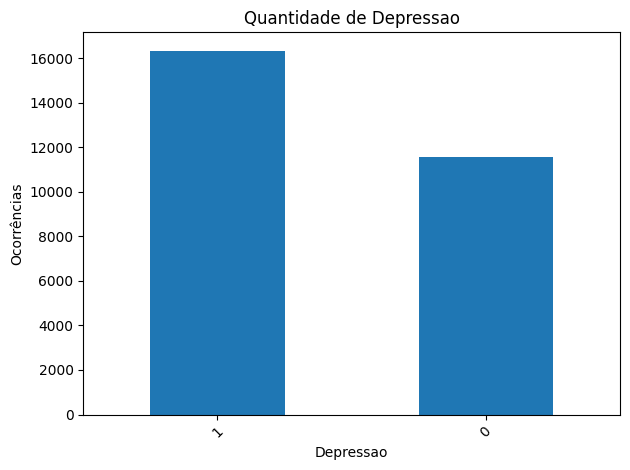

In [57]:
df_dataset['Depression'].value_counts().plot(kind='bar')
plt.title('Quantidade de Depressao')
plt.xlabel('Depressao')
plt.ylabel('Ocorrências')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Total Com Depressão x Sem Depressão

In [58]:
# Total de registros no DataFrame
total_registros = len(df_dataset)

# Soma diagnostico de depressao
total_nao_dep = dep[dep['Depressao'] == 0]['Quantidade'].sum()

# Soma apenas as dep (exclui no depressao(0))
total_dep = dep[dep['Depressao'] != 0]['Quantidade'].sum()

# Calcula a porcentagem
percentual_nao_dep = (total_nao_dep / total_registros) * 100
percentual_dep = (total_dep / total_registros) * 100

# Exibe o resultado
print(f"Total de registros.: {total_registros}")
print(f"Total de sem depressao: {total_nao_dep} ou {percentual_nao_dep:.2f}% do total")
print(f"Total de depressao....: {total_dep} ou {percentual_dep:.2f}% do total")


Total de registros.: 27901
Total de sem depressao: 11565 ou 41.45% do total
Total de depressao....: 16336 ou 58.55% do total


#Engenharia de Dados

##Eliminar Valores Nulos
A eliminação de valores nulos deverá ser feita com cuidados. É necessário avaliar a real necessidade de eliminá-los, pois há alternativas, por exemplo, substituir os valores faltantes pela moda ou pela média.

In [59]:
df_dataset.isnull().sum()

,0
id,0
Gender,0
Age,0
City,0
Profession,0
Academic Pressure,0
Work Pressure,0
CGPA,0
Study Satisfaction,0
Job Satisfaction,0


Não há dados nulos

##Eliminar as Linhas Duplicadas
Já sabemos que não há duplicação, então, este passo não seria necessário, mas fica a título de exemplo

In [60]:
# Quantidade total antes
total_antes = len(df_dataset)

# Quantidade de duplicadas
duplicadas = df_dataset.duplicated().sum()

# Remover duplicadas
df_dataset = df_dataset.drop_duplicates()

# Quantidade total depois
total_depois = len(df_dataset)

print(f"Total de linhas antes......................: {total_antes}")
print(f"Linhas duplicadas detectadas...............: {duplicadas}")
print(f"Total de linhas depois do drop_duplicates(): {total_depois}")

Total de linhas antes......................: 27901
Linhas duplicadas detectadas...............: 0
Total de linhas depois do drop_duplicates(): 27901


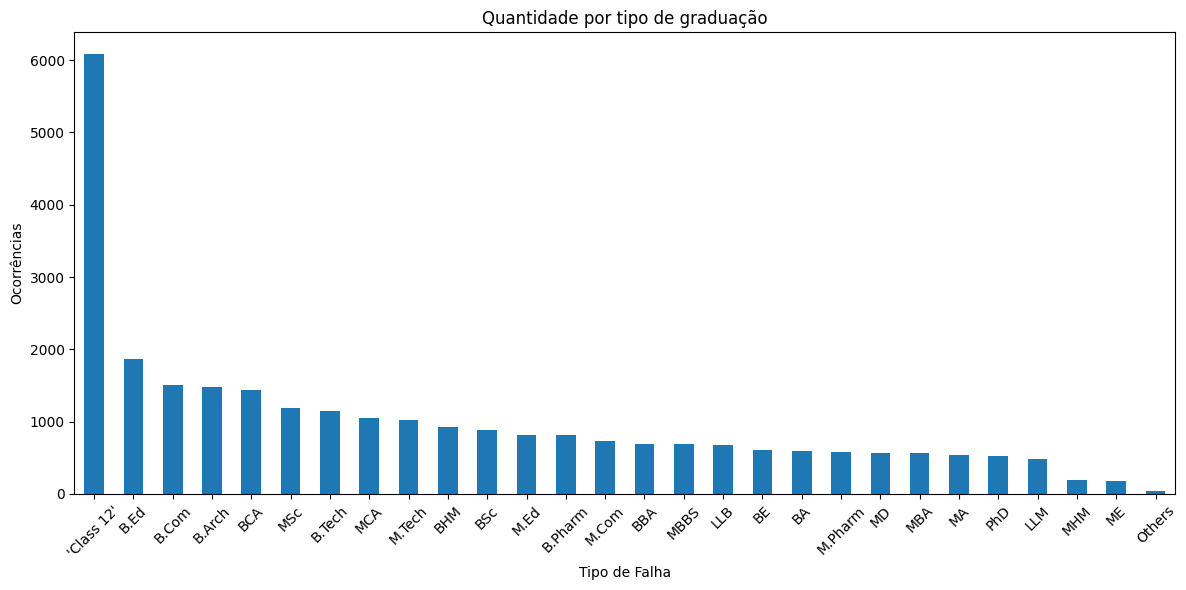

In [61]:
#Exibe um gráfico da quantidade de falhas por 'Failure Code'
plt.figure(figsize=(12, 6))
df_dataset['Degree'].value_counts().plot(kind='bar')
plt.title('Quantidade por tipo de graduação')
plt.xlabel('Tipo de Falha')
plt.ylabel('Ocorrências')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Análise Exploratória dos Dados - 2a Parte
Não há necessidade de repetir os comando da 1a Parte, pois não houve mudança dos dados (nenhum valor nulo, por exemplo). Então, vamos aproveitar para fazer mais análises e gráficos

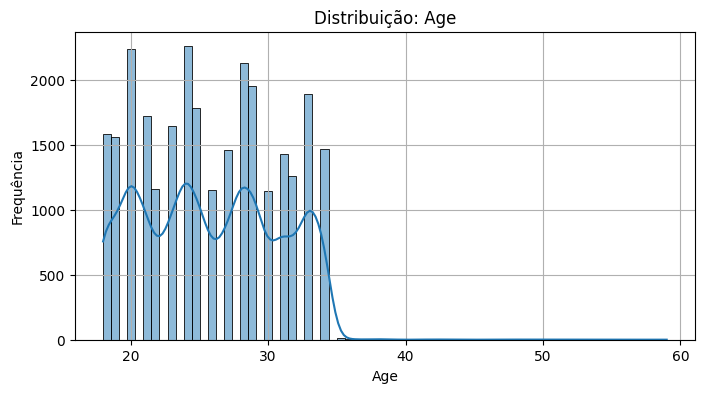

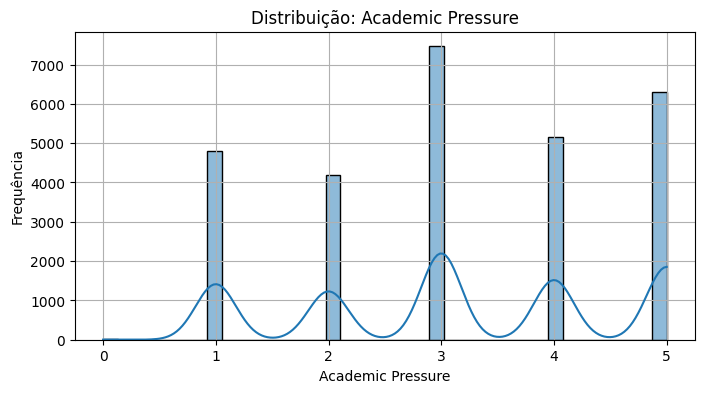

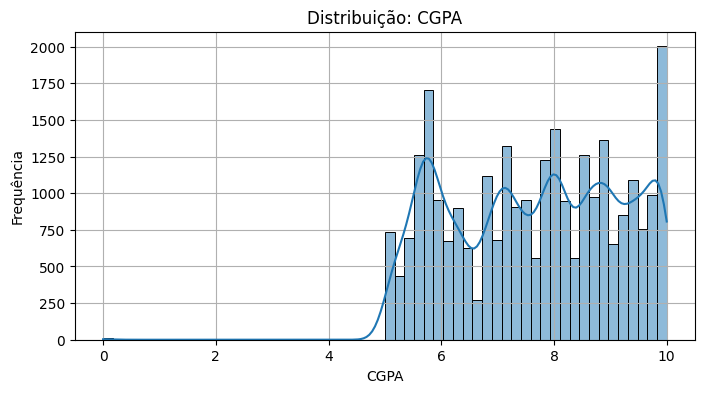

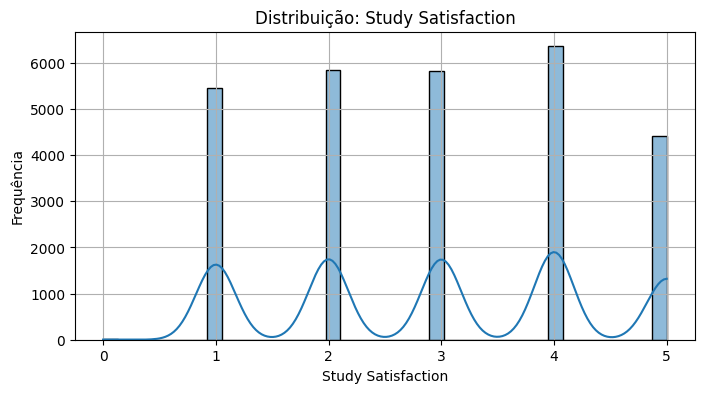

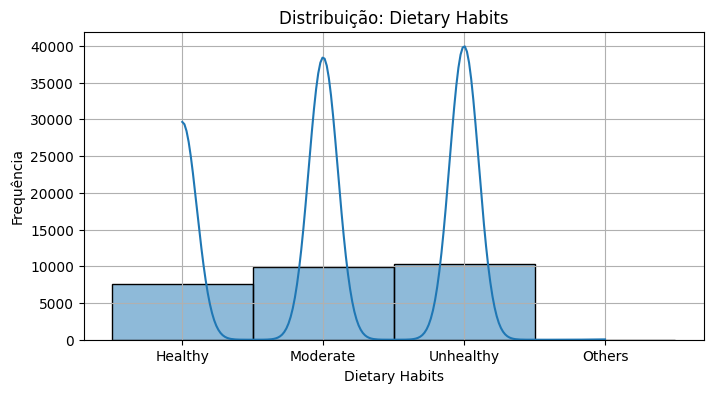

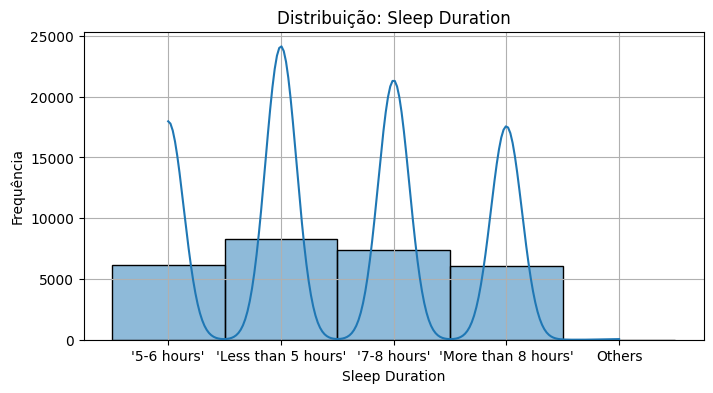

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

variaveis = ['Age', 'Academic Pressure', 'CGPA', 'Study Satisfaction', 'Dietary Habits', 'Sleep Duration']

for var in variaveis:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_dataset[var], kde=True)
    plt.title(f'Distribuição: {var}')
    plt.xlabel(var)
    plt.ylabel("Frequência")
    plt.grid(True)
    plt.show()


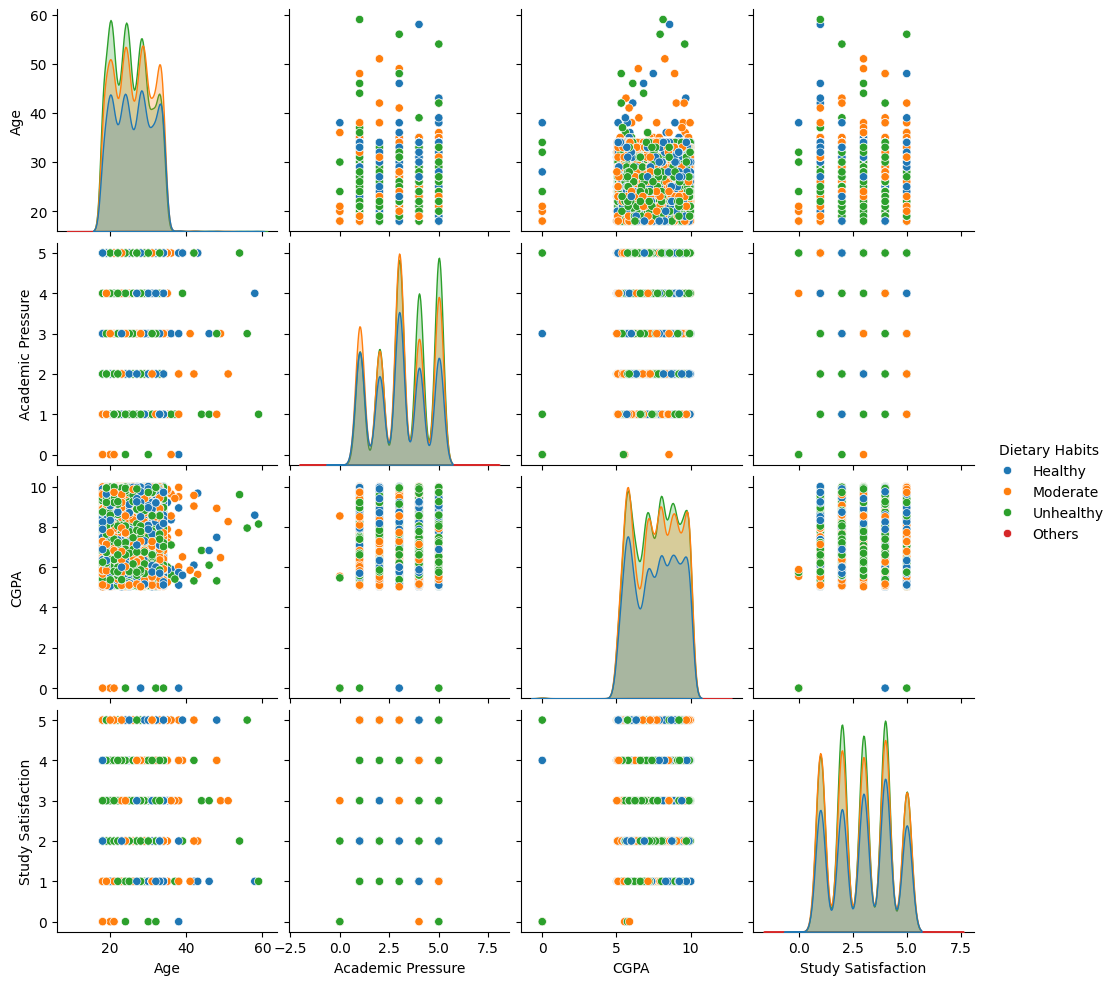

In [63]:
vars_numericas = [c for c in variaveis if pd.api.types.is_numeric_dtype(df_dataset[c])]

sns.pairplot(df_dataset, hue="Dietary Habits", vars=vars_numericas)

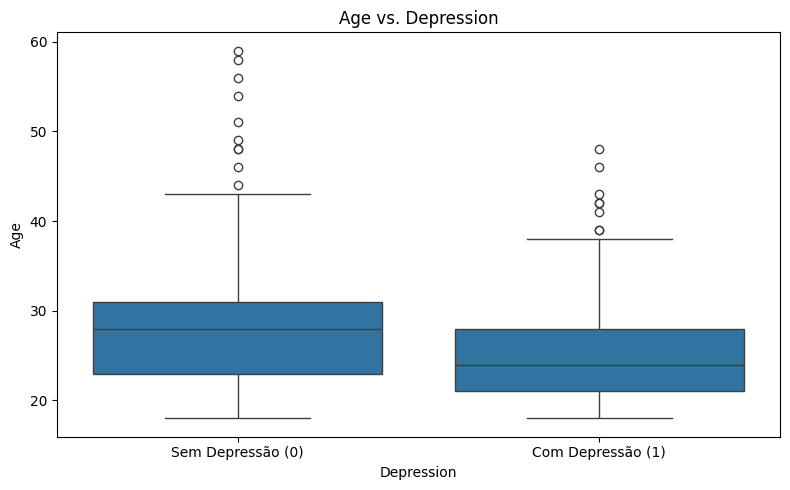

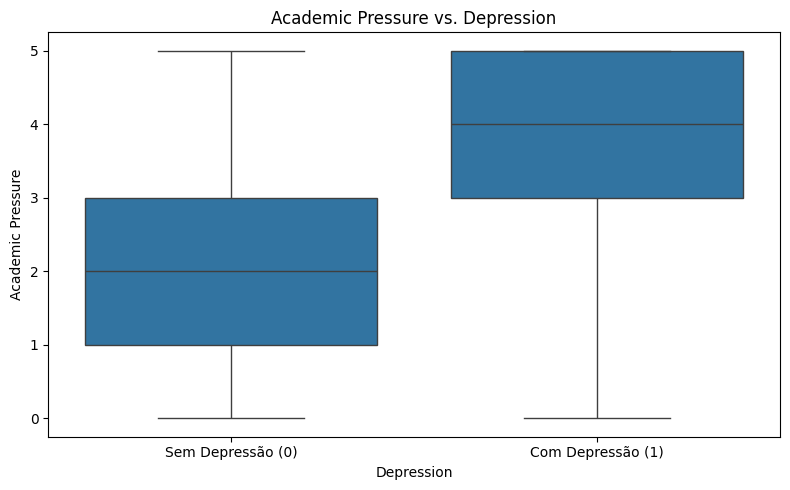

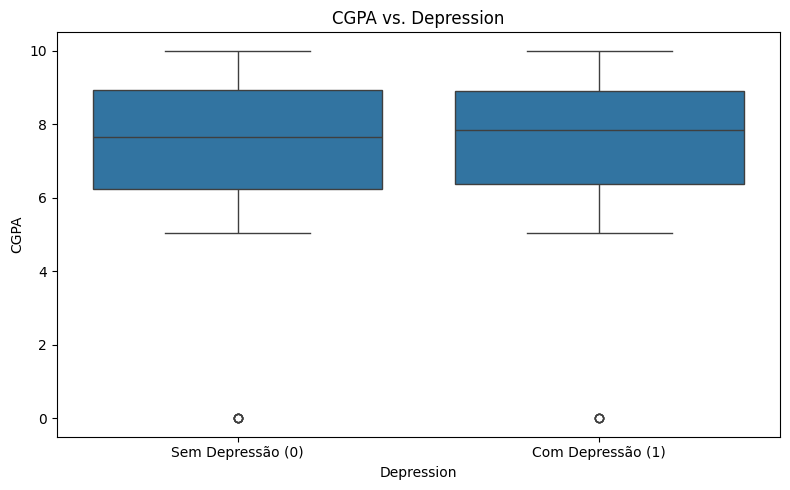

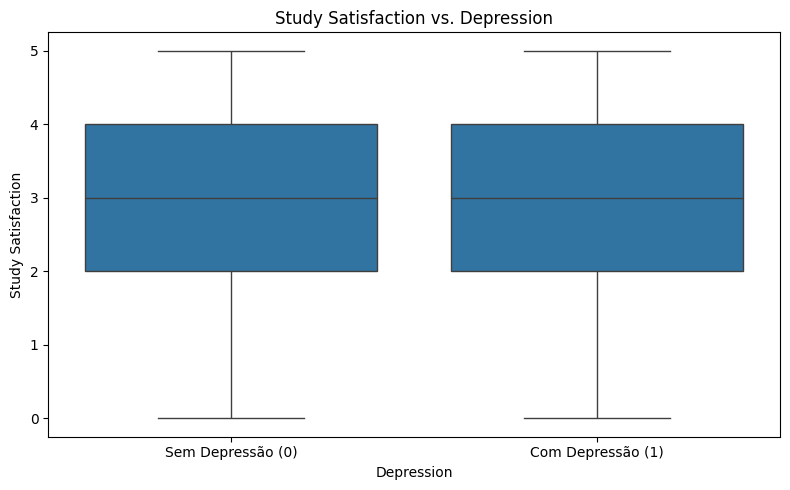

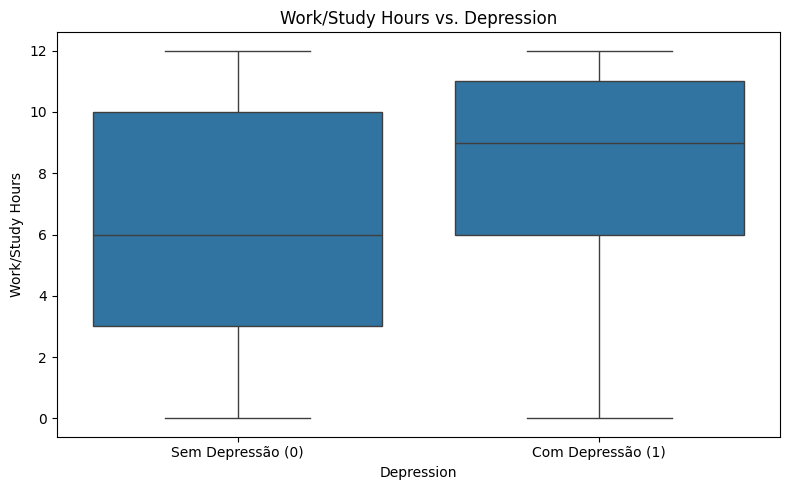

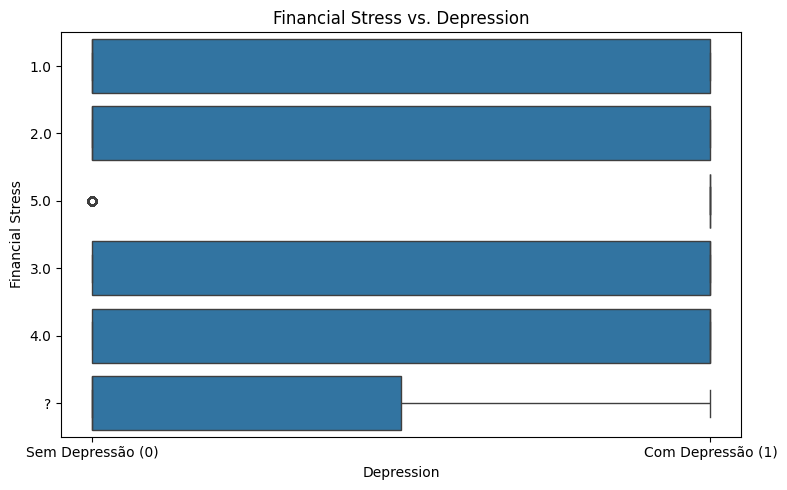

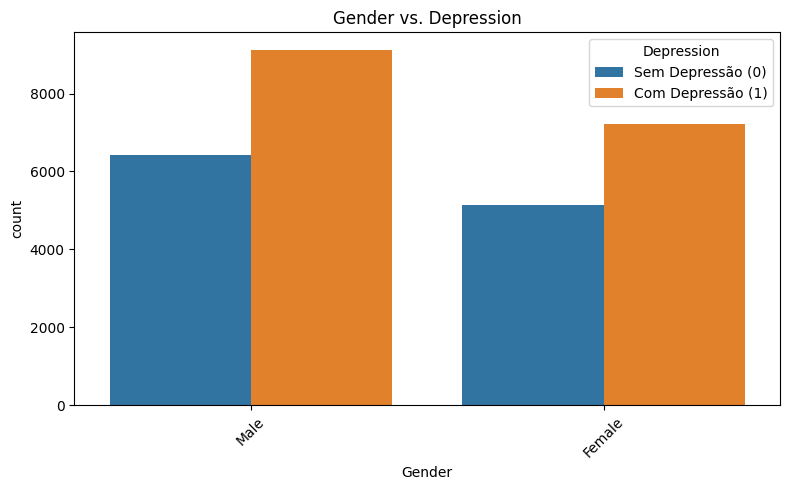

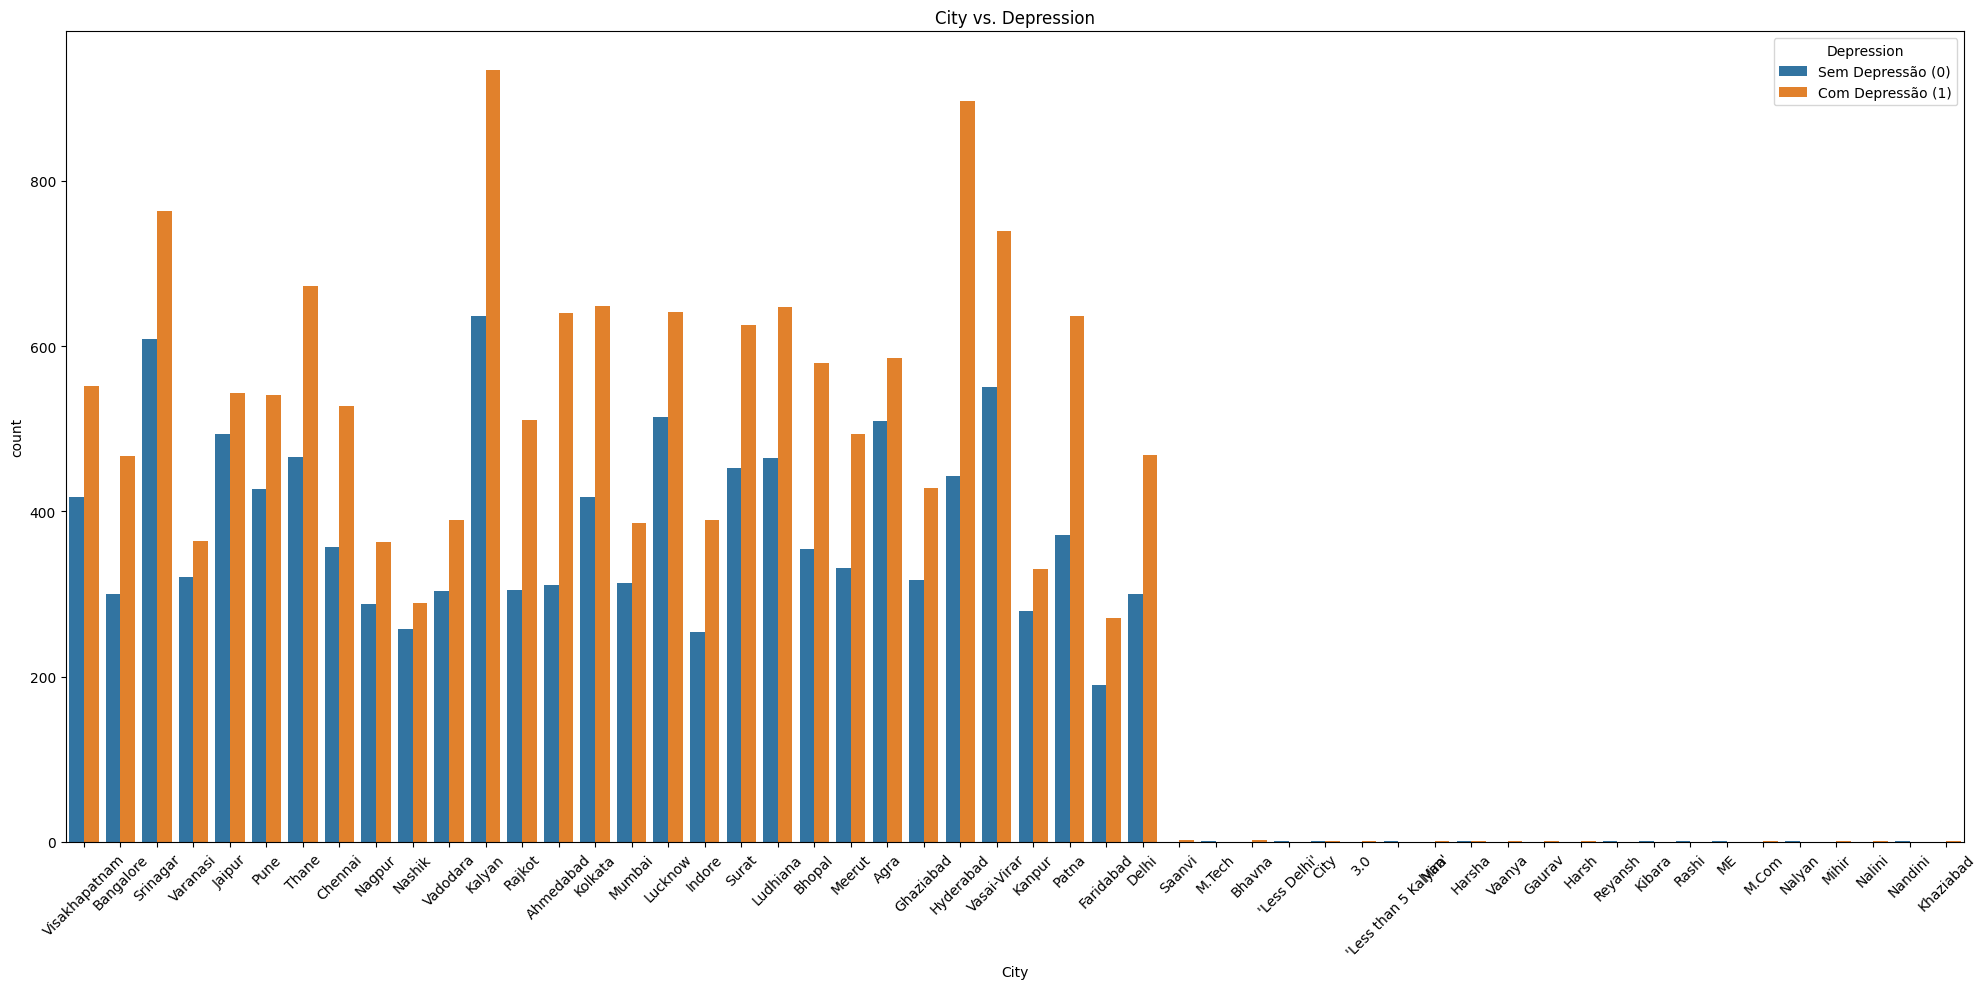

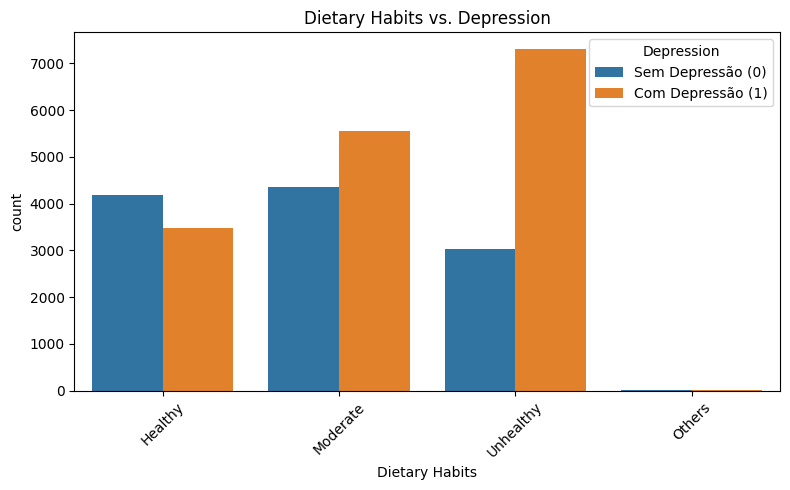

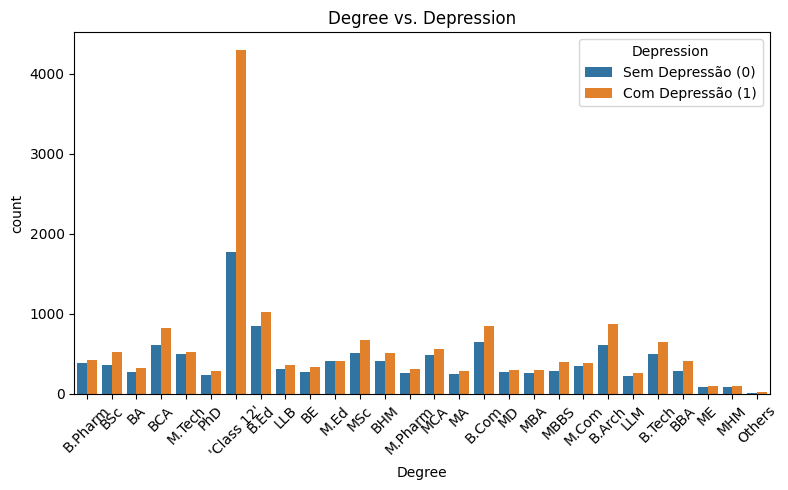

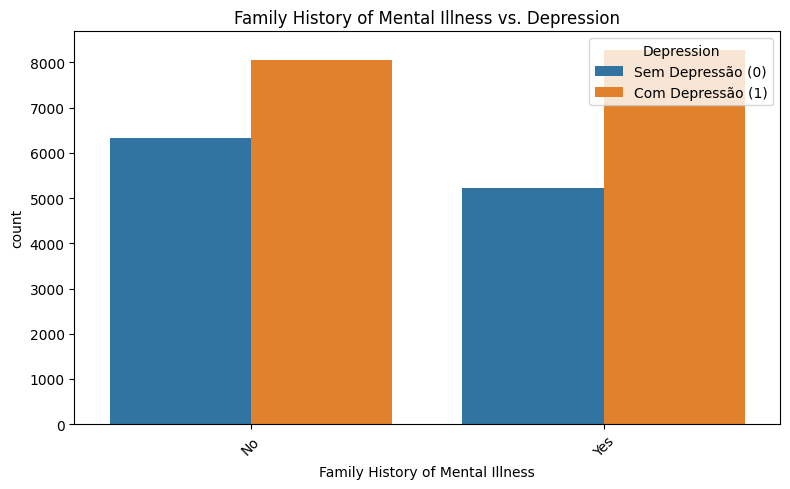

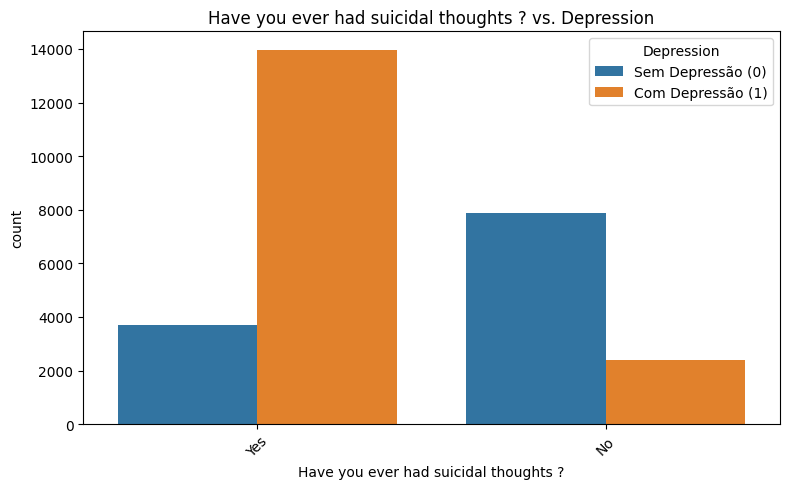

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# BOXPlots - variáveis numéricas
# ===============================
variaveis_numericas = [
    'Age',
    'Academic Pressure',
    'CGPA',
    'Study Satisfaction',
    'Work/Study Hours',
    'Financial Stress'
]

for var in variaveis_numericas:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df_dataset, x='Depression', y=var)
    plt.title(f'{var} vs. Depression')
    plt.xticks([0, 1], ['Sem Depressão (0)', 'Com Depressão (1)'])
    plt.tight_layout()
    plt.show()

# bins = [0, 4, 6, 8, 10, 12]
# labels = ['< 5', '5-6', '7-8', '> 8', 'Others']

# # Criar faixas de sono
# df_dataset['SleepRange'] = pd.cut(df_dataset['Sleep Duration'], bins=bins, labels=labels, right=False)
# df_dataset['SleepRange'] = pd.Categorical(df_dataset['SleepRange'], categories=labels, ordered=True)

# # Contar quantas pessoas há em cada faixa, separadas por depressão
# count_df = df_dataset.groupby(['SleepRange', 'Depression']).size().reset_index(name='Count')

# # Gráfico de barras (aqui está a correção)
# plt.figure(figsize=(8,5))
# sns.barplot(data=count_df, x='SleepRange', y='Count', hue='Depression', palette='Set2')

# plt.title('Contagem de Pessoas com/sem Depressão por Faixa de Sono')
# plt.xlabel('Faixa de Horas de Sono')
# plt.ylabel('Quantidade de Pessoas')
# plt.legend(title='Depressão')
# plt.tight_layout()
# plt.show()

# ===============================
# COUNTPLOTS - variáveis categóricas
# ===============================
variaveis_categoricas = [
    'Gender',
    'City',
    'Dietary Habits',
    'Degree',
    'Family History of Mental Illness',
    'Have you ever had suicidal thoughts ?'
]

for var in variaveis_categoricas:

  if var == 'City':
    plt.figure(figsize=(20, 10))
  else:
    plt.figure(figsize=(8, 5))
  sns.countplot(data=df_dataset, x=var, hue='Depression')
  plt.title(f'{var} vs. Depression')
  plt.xticks(rotation=45)
  plt.legend(title="Depression", labels=["Sem Depressão (0)", "Com Depressão (1)"])
  plt.tight_layout()
  plt.show()



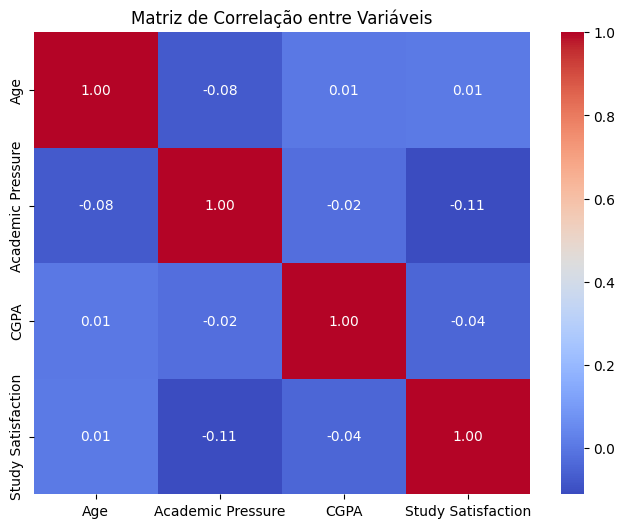

In [65]:
corr_matrix = df_dataset[variaveis].corr(numeric_only=True)

import seaborn as sns, matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação entre Variáveis')
plt.show()

Top pares por |correlação|:
                                      Par  abs_corr
4  Study Satisfaction ↔ Academic Pressure      0.11
0                 Academic Pressure ↔ Age      0.08
5               Study Satisfaction ↔ CGPA      0.04
2                CGPA ↔ Academic Pressure      0.02
3                Study Satisfaction ↔ Age      0.01
1                              CGPA ↔ Age      0.01


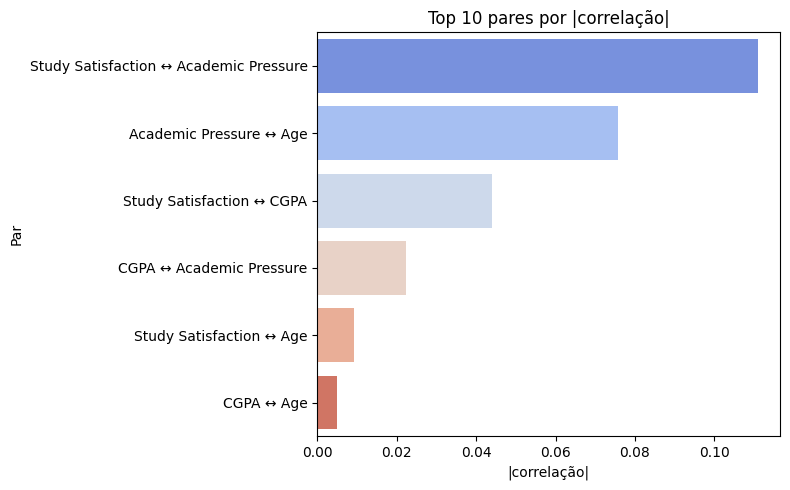

In [66]:
corr = df_dataset[variaveis].corr(numeric_only=True).abs()

mask = np.triu(np.ones_like(corr, dtype=bool))
corr_tri = corr.where(~mask)

pairs = (
    corr_tri.stack()
    .reset_index()
    .rename(columns={'level_0':'Var 1', 'level_1':'Var 2', 0:'abs_corr'})
    .sort_values('abs_corr', ascending=False)
)

top_k = 10
top_pairs = pairs.head(top_k).copy()  # <= evita SettingWithCopyWarning
top_pairs.loc[:, 'Par'] = top_pairs['Var 1'] + ' ↔ ' + top_pairs['Var 2']

print("Top pares por |correlação|:")
print(top_pairs[['Par', 'abs_corr']])

plt.figure(figsize=(8, 5))
sns.barplot(
    data=top_pairs,
    x='abs_corr',
    y='Par',
    hue='Par',          # <= adiciona hue
    legend=False,       # <= remove legenda redundante
    orient='h',
    palette='coolwarm'  # <= agora permitido
)
plt.title(f'Top {top_k} pares por |correlação|')
plt.xlabel('|correlação|')
plt.tight_layout()
plt.show()

# Etapa 3

In [67]:
def rm_lines(df, condition):
    mask = False
    for col, val in condition.items():
        mask |= (df[col] == val)

    return df.drop(df[mask].index)

In [68]:

import random

def remove_lines(df, condition, n):
    deletados = 0
    df = df.copy()

    while deletados < n and not df.empty:
        idx = random.choice(df.index)
        row = df.loc[idx]

        if any(row[col] == val for col, val in condition.items()):
            df = df.drop(idx)
            deletados += 1

    return df


In [69]:
import re

def normalize_columns(df):
    new_cols = []
    for col in df.columns:
        col = col.strip()
        col = col.lower()
        col = re.sub(r'\s+', '_', col)           # espaços → _
        col = re.sub(r'[^a-z0-9_]', '', col)     # remove caracteres especiais
        new_cols.append(col)
    df.columns = new_cols
    return df

In [70]:
#Remove lines with invalid variable value
# indices_to_drop = df_dataset[df_dataset['Financial Stress'] == '?'].index
# idx_a = indices_to_drop.append(df_dataset[df_dataset['Sleep Duration'] == 'Others'].index)
# idx_b = idx_a.append(df_dataset[df_dataset['Degree'] == 'Others'].index)
# idx_c = idx_b.append(df_dataset[df_dataset['Dietary Habits'] == 'Others'].index)

condition = {
    'Financial Stress': '?',
    'Sleep Duration': 'Others',
    'Degree': 'Others',
    'Dietary Habits': 'Others'
    }

df_dropped = rm_lines(df_dataset, condition)

# Drop the identified rows
# df_dropped = df_dataset.drop(idx_c)

In [71]:
#Normalizar dados

sleep_map = {
    "'Less than 5 hours'": 4,
    "'5-6 hours'": 5.5,
    "'7-8 hours'": 7.5,
    "'More than 8 hours'": 9,
     'Others': 0
}
if 'Sleep Duration' in df_dropped.columns:
    df_dropped['Sleep Duration'] = df_dropped['Sleep Duration'].map(sleep_map)

degree_map = {
    "'Class 12'": 1,
    'B.Arch': 2,
    'B.Com': 2,
    'B.Ed': 2,
    'B.Pharm': 2,
    'B.Tech': 2,
    'BA': 2,
    'BBA': 2,
    'BCA': 2,
    'BE': 2,
    'BHM': 2,
    'BSc': 2,
    'LLB': 2,
    'LLM': 4,
    'M.Com': 4,
    'M.Ed': 4,
    'M.Pharm': 4,
    'M.Tech': 4,
    'MA': 4,
    'MBA': 3,
    'MBBS': 2,
    'MCA': 4,
    'MD': 5,
    'ME': 4,
    'MHM': 4,
    'MSc': 4,
    'PhD': 5,
    'Others': 0
}

if 'Degree' in df_dropped.columns:
    df_dropped['Degree'] = df_dropped['Degree'].map(degree_map)

diet_map = {
    'Healthy': 3,
    'Moderate': 2,
    'Unhealthy': 1,
    'Others': 0
}

if 'Dietary Habits' in df_dropped.columns:
    df_dropped['Dietary Habits'] = df_dropped['Dietary Habits'].map(diet_map)

binary_map = {
    'Yes': 1,
    'No': 0,
}

gender_map = {
    'Male': 1,
    'Female': 0,
}

if 'Have you ever had suicidal thoughts ?' in df_dropped.columns:
    df_dropped['Have you ever had suicidal thoughts ?'] = df_dropped['Have you ever had suicidal thoughts ?'].map(binary_map)

if 'Family History of Mental Illness' in df_dropped.columns:
    df_dropped['Family History of Mental Illness'] = df_dropped['Family History of Mental Illness'].map(binary_map)

if 'Gender' in df_dropped.columns:
    df_dropped['Gender'] = df_dropped['Gender'].map(gender_map)

# Codificar variáveis categóricas
categorical = df_dropped.select_dtypes(include='object').columns
le = LabelEncoder()
for col in categorical:
    df_dropped[col] = le.fit_transform(df_dropped[col])


In [72]:
dep = df_dropped['Depression'].value_counts().reset_index()
dep.columns = ['Depressao', 'Quantidade']

In [73]:
# #Balanceamento
# total_nao_dep = dep[dep['Depressao'] == 0]['Quantidade'].sum()
# total_dep = dep[dep['Depressao'] != 0]['Quantidade'].sum()

# del_l = int((total_dep - total_nao_dep)* 0.98)

# condition = {'Depression': 1}
# df_dropped = remove_lines(df_dropped, condition, del_l)

In [74]:
dep = df_dropped['Depression'].value_counts().reset_index()
dep.columns = ['Depressao', 'Quantidade']
print(dep)

   Depressao  Quantidade
0          1       16297
1          0       11536


In [76]:
#Normalizar cabecario

df_dropped =  normalize_columns(df_dropped)
df_dropped = df_dropped.rename(columns={
    "have_you_ever_had_suicidal_thoughts_": "suicidal_thoughts",
    "family_history_of_mental_illness": "family_illness",
})

In [77]:
features = df_dropped[['age', 'academic_pressure','study_satisfaction', 'dietary_habits','degree','suicidal_thoughts','workstudy_hours','financial_stress']]
target = df_dropped[['depression']]

In [78]:
features.head()

,age,academic_pressure,study_satisfaction,dietary_habits,degree,suicidal_thoughts,workstudy_hours,financial_stress
0,33.00,5.00,2.00,3,2,1,3.00,0
1,24.00,2.00,5.00,2,2,0,3.00,1
2,31.00,3.00,5.00,3,2,0,9.00,0
3,28.00,3.00,2.00,2,2,1,4.00,4
4,25.00,4.00,3.00,2,4,1,1.00,0


suicidal_thoughts    0.16
academic_pressure    0.12
financial_stress     0.07
age                  0.03
dietary_habits       0.02
workstudy_hours      0.02
study_satisfaction   0.02
degree               0.00
dtype: float64


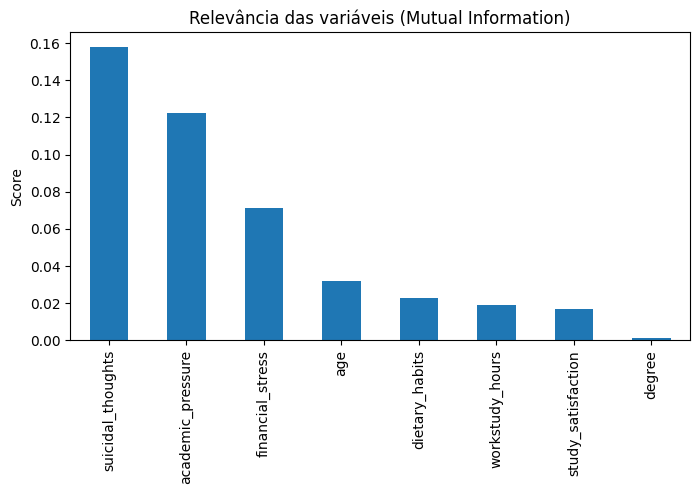

In [79]:
# Calcular mutual information entre cada feature e a classe
mi = mutual_info_classif(features, target.values.ravel(), random_state=42)

mi_series = pd.Series(mi, index=features.columns).sort_values(ascending=False)

# Visualizar
print(mi_series)

# Gráfico de barras
mi_series.plot(kind="bar", figsize=(8,4), title="Relevância das variáveis (Mutual Information)")
plt.ylabel("Score")
plt.show()

In [80]:
X_train, X_test, y_train, y_test = train_test_split(features, target.values.ravel(), test_size=0.2, random_state=42, stratify=target)

# Contagem simples
print("Distribuição em y_train:")
print(pd.Series(y_train).value_counts())

print("\nDistribuição em y_test:")
print(pd.Series(y_test).value_counts())

# Se quiser formatar mais bonito:
print("\nDistribuição em y_train (percentual):")
print(pd.Series(y_train).value_counts(normalize=True))

print("\nDistribuição em y_test (percentual):")
print(pd.Series(y_test).value_counts(normalize=True))

Distribuição em y_train:
1    13037
0     9229
Name: count, dtype: int64

Distribuição em y_test:
1    3260
0    2307
Name: count, dtype: int64

Distribuição em y_train (percentual):
1   0.59
0   0.41
Name: proportion, dtype: float64

Distribuição em y_test (percentual):
1   0.59
0   0.41
Name: proportion, dtype: float64


#Chamar modelo


In [81]:

model = LGBMClassifier(
    objective='binary',
    random_state=42,
    num_leaves=31,
    max_depth=-10,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.7,
    colsample_bytree=1.0
    )

# Etapa 4

## GridSearchCV

In [82]:
# model = LGBMClassifier(objective='binary', random_state=42)

# # Definir os parâmetros para busca
# param_grid = {
#     'num_leaves': [31, 50, 100],
#     'max_depth': [-1, 10, 20],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': [100, 200, 300],
#     'subsample': [0.7, 0.8, 1.0],
#     'colsample_bytree': [0.7, 0.8, 1.0],
#     'min_child_samples': [20, 30, 40]
# }

# # Configurar e rodar o GridSearchCV
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
# grid_search.fit(X_train, y_train)

# # Mostrar os melhores parâmetros encontrados
# print(f"Melhores parâmetros: {grid_search.best_params_}")

# # Avaliar no conjunto de teste
# best_model = grid_search.best_estimator_
# print(f"Acurácia no teste: {best_model.score(X_test, y_test)}")

# Melhores parâmetros: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 30, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 0.7}
# Acurácia no teste: 0.8537812107059457

#

#Treinamento

In [83]:
# fit(): ensina o modelo a fazer previsões com os dados de treino.
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 13037, number of negative: 9229
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 69
[LightGBM] [Info] Number of data points in the train set: 22266, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.585512 -> initscore=0.345441
[LightGBM] [Info] Start training from score 0.345441


LGBMClassifier(max_depth=-10, objective='binary', random_state=42,
               subsample=0.7)

In [84]:
# Retorna o rótulo previsto para cada amostra (ex.: 0, 1, 2, 3, 4, 5).
y_pred = model.predict(X_test)
print(y_pred)

[1 1 1 ... 1 0 1]


In [85]:
# Retorna as probabilidades por classe para cada amostra.
y_proba = model.predict_proba(X_test)
print(y_proba)

[[0.22624658 0.77375342]
 [0.28130257 0.71869743]
 [0.04214591 0.95785409]
 ...
 [0.02941014 0.97058986]
 [0.70338326 0.29661674]
 [0.3917508  0.6082492 ]]


##Salvar predicoes

In [86]:
# previsões e probabilidades no teste
classes = model.classes_

# garante um DataFrame de saída com as colunas originais
if isinstance(X_test, pd.DataFrame):
    df_out = X_test.copy()
else:
    df_out = pd.DataFrame(X_test, columns=features.columns)

# adiciona rótulos verdadeiro e predito
df_out["y_true"] = np.asarray(y_test)
df_out["y_pred"] = y_pred
# Adiciona a confiança da classe prevista
idx = y_proba.argmax(axis=1)
df_out["proba_pred"] = y_proba[np.arange(len(y_proba)), idx]

# adiciona as probabilidades por classe (uma coluna por classe)
for i, cls in enumerate(classes):
    df_out[f"proba_{cls}"] = y_proba[:, i]

df_out.head()

# from google.colab import drive
# drive.mount("/content/drive")  # autorize

# caminho_drive = "/content/drive/MyDrive/predicoes_teste.xlsx"
# df_out.to_excel(caminho_drive, index=False)
# print("Salvo em:", caminho_drive)

,age,academic_pressure,study_satisfaction,dietary_habits,degree,suicidal_thoughts,workstudy_hours,financial_stress,y_true,y_pred,proba_pred,proba_0,proba_1
6798,25.00,3.00,3.00,2,2,1,12.00,1,1,1,0.77,0.23,0.77
12292,28.00,3.00,3.00,3,2,1,2.00,4,1,1,0.72,0.28,0.72
18026,24.00,5.00,1.00,2,2,1,12.00,1,1,1,0.96,0.04,0.96
12543,22.00,5.00,2.00,2,4,0,2.00,0,0,0,0.62,0.62,0.38
17554,18.00,2.00,4.00,1,1,1,9.00,4,1,1,0.93,0.07,0.93


In [87]:
# import joblib

# filename = "/content/drive/MyDrive/joblib_model.sav"
# joblib.dump(model, filename)

In [88]:
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred, zero_division=0))


Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.84      0.79      0.82      2307
           1       0.86      0.90      0.88      3260

    accuracy                           0.85      5567
   macro avg       0.85      0.84      0.85      5567
weighted avg       0.85      0.85      0.85      5567



In [89]:
sm = SMOTE(random_state=42)
X_tr_sm, y_tr_sm = sm.fit_resample(X_train, y_train)
model_sm = LGBMClassifier(max_depth=10, n_estimators=200, random_state=42)
model_sm.fit(X_tr_sm, y_tr_sm)
y_pred_sm = model_sm.predict(X_test)
print(classification_report(y_test, y_pred_sm, digits=3))

[LightGBM] [Info] Number of positive: 13037, number of negative: 13037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 26074, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

           0      0.834     0.802     0.818      2307
           1      0.864     0.887     0.875      3260

    accuracy                          0.852      5567
   macro avg      0.849     0.845     0.846      5567
weighted avg      0.851     0.852     0.851      5567



In [90]:
print("Balanced Acc (Base) :", balanced_accuracy_score(y_test, y_pred))
print("Balanced Acc (SMOTE):", balanced_accuracy_score(y_test, y_pred_sm))

Balanced Acc (Base) : 0.844815193024165
Balanced Acc (SMOTE): 0.8445752590807918


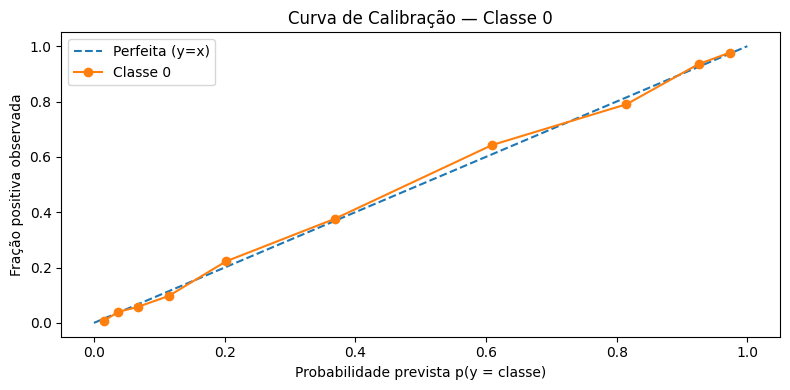

Brier score (classe 0): 0.1057


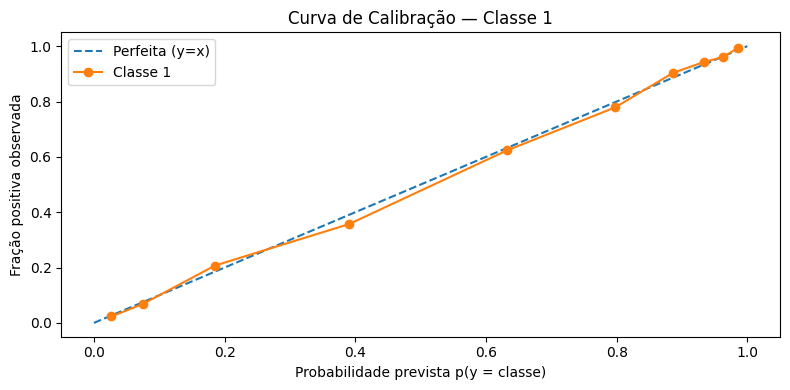

Brier score (classe 1): 0.1057


In [91]:
y_proba = model.predict_proba(X_test)
classes = model.classes_

# Padronização do n_bins = 10
N_BINS = 10

# Uma curva por classe (one-vs-rest)
for k, cls in enumerate(classes):
    y_true_bin = (y_test == cls).astype(int)
    frac_pos, mean_pred = calibration_curve(y_true_bin, y_proba[:, k], n_bins=N_BINS, strategy="quantile")

    plt.figure(figsize=(8,4))
    plt.plot([0,1], [0,1], "--", label="Perfeita (y=x)")
    plt.plot(mean_pred, frac_pos, marker="o", label=f"Classe {cls}")
    plt.xlabel("Probabilidade prevista p(y = classe)")
    plt.ylabel("Fração positiva observada")
    plt.title(f"Curva de Calibração — Classe {cls}")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

    # Métrica quantitativa de calibração (Brier score) para a classe k
    bs = brier_score_loss(y_true_bin, y_proba[:, k])
    print(f"Brier score (classe {cls}): {bs:.4f}")

[LightGBM] [Info] Number of positive: 10429, number of negative: 7383
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 69
[LightGBM] [Info] Number of data points in the train set: 17812, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.585504 -> initscore=0.345410
[LightGBM] [Info] Start training from score 0.345410
[LightGBM] [Info] Number of positive: 10429, number of negative: 7384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 67
[LightGBM] [Info] Number of data points in the train set: 17813, number of used features: 8
[LightGBM] [Info] [binary:Bo

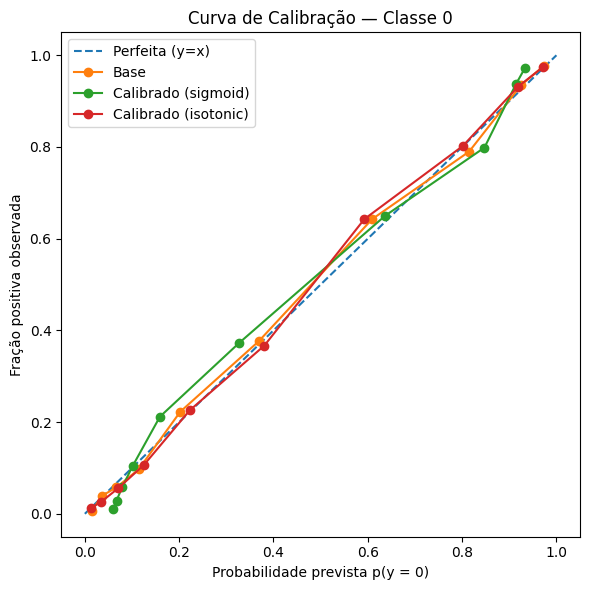

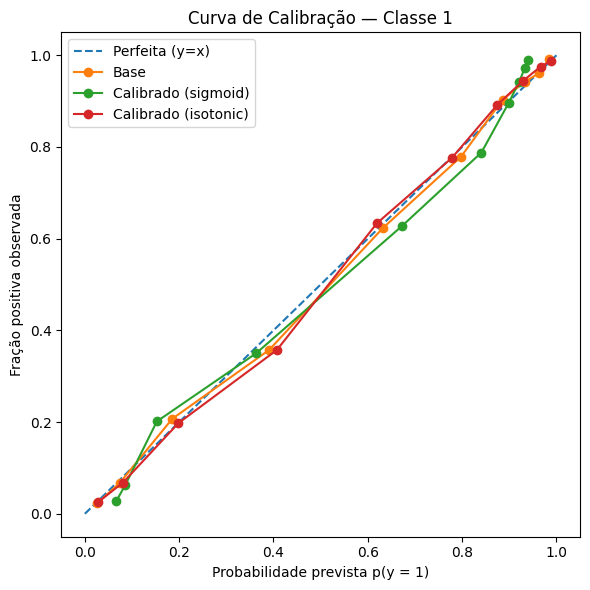

In [92]:
# 1) Treinar versões calibradas do modelo-base
# Use cv>=3 para evitar vazamento simples
cal_sig = CalibratedClassifierCV(model, method="sigmoid", cv=5)
cal_sig.fit(X_train, y_train)

# Use cv>=5 para evitar vazamento simples; isotonic precisa de mais dados
cal_iso = CalibratedClassifierCV(model, method="isotonic", cv=5)
cal_iso.fit(X_train, y_train)

# 2) Probabilidades no conjunto de teste
models = {
    "Base": model,
    "Calibrado (sigmoid)": cal_sig,
    "Calibrado (isotonic)": cal_iso,
}
probas = {name: m.predict_proba(X_test) for name, m in models.items()}
classes = model.classes_

# 3) Curvas de calibração por classe
# strategy='quantile' tende a deixar os bins com tamanhos parecidos (mais estável em desbalanceamento)
for k, cls in enumerate(classes):
    y_true_bin = (y_test == cls).astype(int)

    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], "--", label="Perfeita (y=x)")

    for name, P in probas.items():
        frac_pos, mean_pred = calibration_curve(
            y_true_bin, P[:, k], n_bins=N_BINS, strategy="quantile"
        )
        plt.plot(mean_pred, frac_pos, marker="o", label=name)

    plt.xlabel(f"Probabilidade prevista p(y = {cls})")
    plt.ylabel("Fração positiva observada")
    plt.title(f"Curva de Calibração — Classe {cls}")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

In [93]:
# 1) Brier por classe (↓ melhor) usando o mesmo 'probas'
rows = []
for name, P in probas.items():
    for k, cls in enumerate(classes):
        y_true_bin = (np.asarray(y_test) == cls).astype(int)
        rows.append([name, cls, brier_score_loss(y_true_bin, P[:, k])])
df_brier = (pd.DataFrame(rows, columns=["Modelo","Classe","Brier (OVR)"])
              .pivot(index="Classe", columns="Modelo", values="Brier (OVR)")
              .sort_index())
display(df_brier.round(4))

# 2) ECE helper (só cria se não existir ainda)
if "ece" not in globals():
    def ece(probs, y_true, n_bins=10):
        bins = np.linspace(0,1,n_bins+1)
        conf = probs.max(axis=1); preds = probs.argmax(axis=1)
        acc  = (preds == np.asarray(y_true)).astype(float)
        val = 0.0
        for i in range(n_bins):
            m = (conf>=bins[i]) & (conf<bins[i+1])
            if m.any():
                val += abs(acc[m].mean() - conf[m].mean()) * m.mean()
        return val

# 3) Refazer os cálculo, por garantia
y_pred_base = model.predict(X_test)
# Smote
y_pred_sm   = model_sm.predict(X_test)
# Calibrado (sigmoid): veio do Script 1 (cal_sig).
y_pred_cal_sig = cal_sig.predict(X_test)
# Calibrado (isotonic): veio do Script 1 (cal_iso).
y_pred_cal_iso = cal_iso.predict(X_test)

# 4) Tabela final (use as probabilidades/predições do mesmo dicionário 'probas')
linhas = [{
    "Modelo": "Base",
    "Accuracy": accuracy_score(y_test, y_pred_base),
    "Balanced Acc.": balanced_accuracy_score(y_test, y_pred_base),
    "Macro-F1": f1_score(y_test, y_pred_base, average="macro", zero_division=0),
    "LogLoss": log_loss(y_test, probas["Base"], labels=classes),
    "ECE": ece(probas["Base"], y_test, 10),
}]

probas["SMOTE"] = model_sm.predict_proba(X_test)
linhas.append({
    "Modelo": "SMOTE",
    "Accuracy": accuracy_score(y_test, y_pred_sm),
    "Balanced Acc.": balanced_accuracy_score(y_test, y_pred_sm),
    "Macro-F1": f1_score(y_test, y_pred_sm, average="macro", zero_division=0),
    "LogLoss": log_loss(y_test, probas["SMOTE"], labels=classes),
    "ECE": ece(probas["SMOTE"], y_test, 10),
})

linhas.append({
    "Modelo": "Calibrado (sigmoid)",
    "Accuracy": accuracy_score(y_test, y_pred_cal_sig),
    "Balanced Acc.": balanced_accuracy_score(y_test, y_pred_cal_sig),
    "Macro-F1": f1_score(y_test, y_pred_cal_sig, average="macro", zero_division=0),
    "LogLoss": log_loss(y_test, probas["Calibrado (sigmoid)"], labels=classes),
    "ECE": ece(probas["Calibrado (sigmoid)"], y_test, 10),
})

linhas.append({
    "Modelo": "Calibrado (isotonic)",
    "Accuracy": accuracy_score(y_test, y_pred_cal_iso),
    "Balanced Acc.": balanced_accuracy_score(y_test, y_pred_cal_iso),
    "Macro-F1": f1_score(y_test, y_pred_cal_iso, average="macro", zero_division=0),
    "LogLoss": log_loss(y_test, probas["Calibrado (isotonic)"], labels=classes),
    "ECE": ece(probas["Calibrado (isotonic)"], y_test, 10),
})

df_resultados = pd.DataFrame(linhas).round(4)
display(df_resultados)


Modelo,Base,Calibrado (isotonic),Calibrado (sigmoid)
Classe,,,
0,0.11,0.11,0.11
1,0.11,0.11,0.11


,Modelo,Accuracy,Balanced Acc.,Macro-F1,LogLoss,ECE
0,Base,0.85,0.84,0.85,0.34,0.01
1,SMOTE,0.85,0.84,0.85,0.35,0.01
2,Calibrado (sigmoid),0.85,0.85,0.85,0.35,0.03
3,Calibrado (isotonic),0.85,0.84,0.85,0.34,0.01


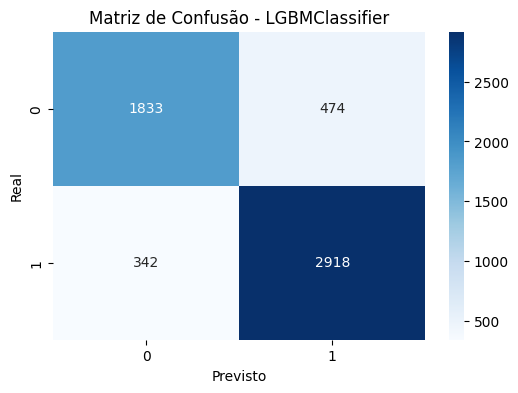

In [94]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão - LGBMClassifier")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

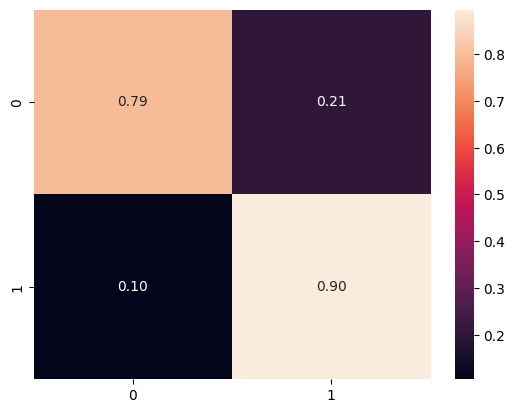

In [95]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2f'); plt.show()

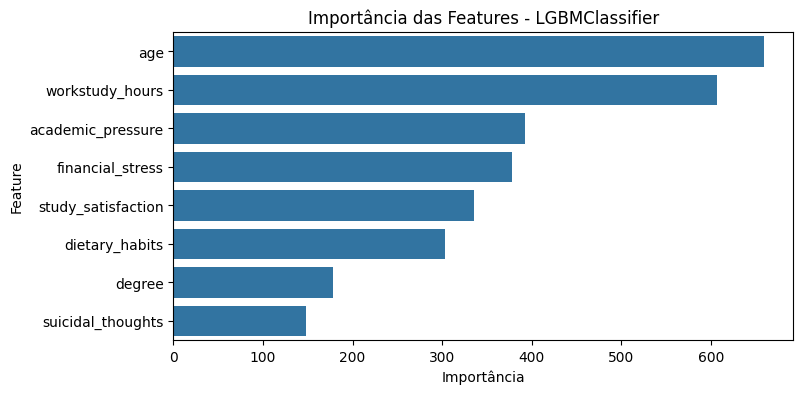

In [96]:
importancias = model.feature_importances_
feature_names = features.columns
importancia_df = pd.DataFrame({'Feature': feature_names, 'Importância': importancias})
importancia_df = importancia_df.sort_values(by='Importância', ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(data=importancia_df, x='Importância', y='Feature')
plt.title('Importância das Features - LGBMClassifier')
plt.show()

suicidal_thoughts     0.11
academic_pressure     0.09
financial_stress      0.04
age                   0.02
workstudy_hours       0.01
dietary_habits        0.01
study_satisfaction    0.00
degree               -0.00
dtype: float64


<Axes: title={'center': 'Permutation Importance'}>

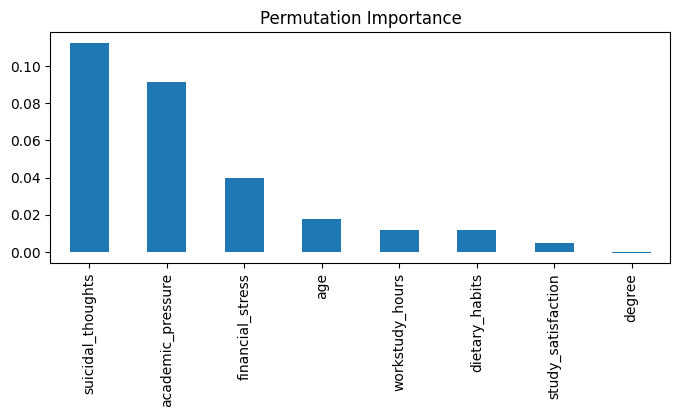

In [97]:
# No conjunto de teste (para não superestimar)
result = permutation_importance(model, X_test, y_test, scoring="f1_macro",
                                n_repeats=20, random_state=42, n_jobs=-1)

importances = pd.Series(result.importances_mean, index=features.columns)
importances = importances.sort_values(ascending=False)

print(importances)

# Gráfico
importances.plot(kind="bar", figsize=(8,3), title="Permutation Importance")


=== Permutation Importance focada na classe 1 (F1-binário) ===


,0
suicidal_thoughts,0.09
academic_pressure,0.07
financial_stress,0.03
age,0.01
workstudy_hours,0.01
dietary_habits,0.01
study_satisfaction,0.00
degree,-0.00


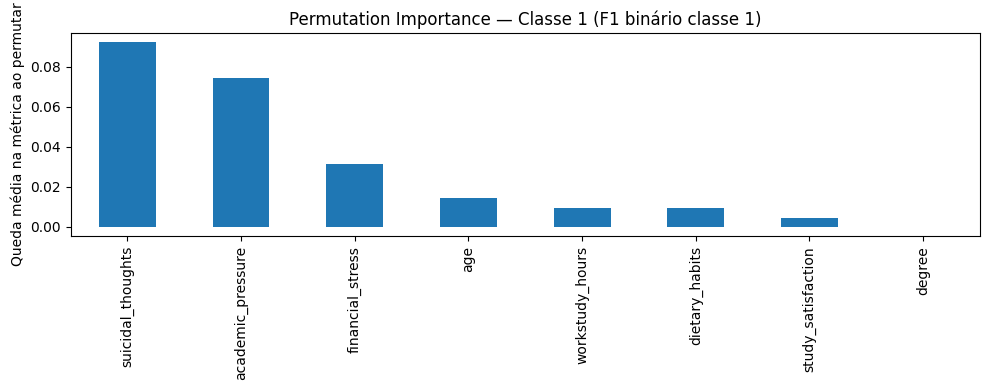


=== Permutation Importance focada na classe 3 (F1-binário) ===


,0
age,0.00
academic_pressure,0.00
study_satisfaction,0.00
dietary_habits,0.00
degree,0.00
suicidal_thoughts,0.00
workstudy_hours,0.00
financial_stress,0.00


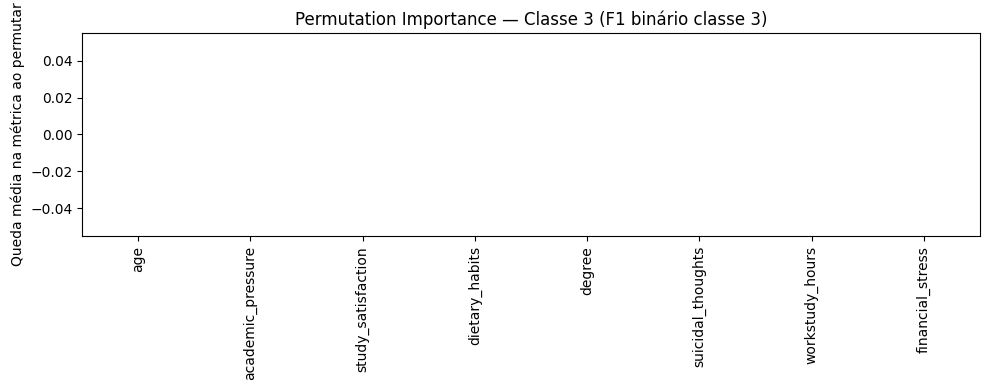


=== Permutation Importance focada na classe 5 (F1-binário) ===


,0
age,0.00
academic_pressure,0.00
study_satisfaction,0.00
dietary_habits,0.00
degree,0.00
suicidal_thoughts,0.00
workstudy_hours,0.00
financial_stress,0.00


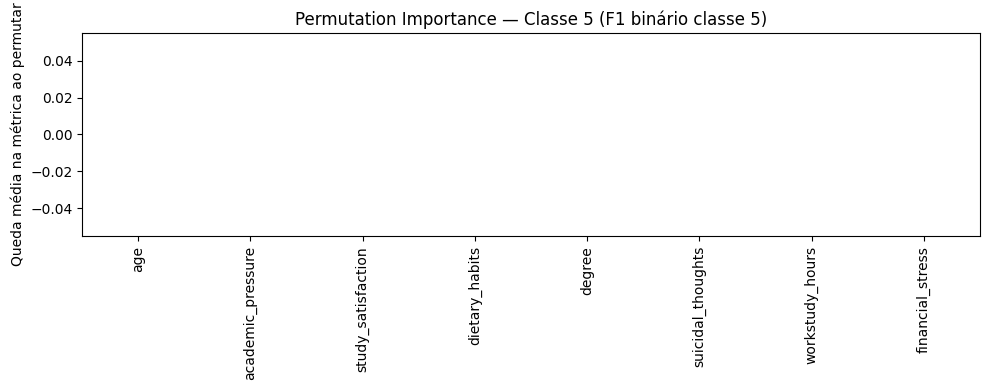

In [98]:
classes = model.classes_
classes_interesse = [1, 3, 5]   # ajuste as classes de interesse

def scorer_para_classe_k_factory(k):
    # k é o rótulo inteiro da classe (ex.: 1, 3, 5)
    def _scorer(estimator, X, y_true_bin):
        # Prediz classe argmax e transforma em binário (1 se ==k, 0 caso contrário)
        y_pred_bin = (estimator.predict(X) == k).astype(int)
        return f1_score(y_true_bin, y_pred_bin, zero_division=0)
    return _scorer

for k in classes_interesse:
    print(f"\n=== Permutation Importance focada na classe {k} (F1-binário) ===")
    y_true_bin = (y_test == k).astype(int)

    result_k = permutation_importance(
        model, X_test, y_true_bin,
        scoring=scorer_para_classe_k_factory(k),
        n_repeats=20, random_state=42, n_jobs=-1
    )

    pi_k = pd.Series(result_k.importances_mean, index=features.columns).sort_values(ascending=False)
    display(pi_k)

    plt.figure(figsize=(10,4))
    pi_k.plot(kind="bar")
    plt.title(f"Permutation Importance — Classe {k} (F1 binário classe {k})")
    plt.ylabel("Queda média na métrica ao permutar")
    plt.tight_layout()
    plt.show()